<a href="https://colab.research.google.com/github/aneesh98/DamageGradePrediction/blob/master/RichterPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np 
import scipy
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, power_transform, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier

In [30]:
df = pd.read_csv('https://s3.amazonaws.com/drivendata/data/57/public/train_values.csv')
labels = pd.read_csv('https://s3.amazonaws.com/drivendata/data/57/public/train_labels.csv')
print(df.head())
print(df.columns.values)
print(labels.head())
# df.drop(columns = ['building_id', 'geo_level_1_id, geo_level_2_id, geo_level_3_id'], axis = 1, inplace = True)
df = pd.concat([df.iloc[:,1:], labels.iloc[:,1]], axis = 1)
df.columns.values

   building_id  ...  has_secondary_use_other
0       802906  ...                        0
1        28830  ...                        0
2        94947  ...                        0
3       590882  ...                        0
4       201944  ...                        0

[5 rows x 39 columns]
['building_id' 'geo_level_1_id' 'geo_level_2_id' 'geo_level_3_id'
 'count_floors_pre_eq' 'age' 'area_percentage' 'height_percentage'
 'land_surface_condition' 'foundation_type' 'roof_type'
 'ground_floor_type' 'other_floor_type' 'position' 'plan_configuration'
 'has_superstructure_adobe_mud' 'has_superstructure_mud_mortar_stone'
 'has_superstructure_stone_flag' 'has_superstructure_cement_mortar_stone'
 'has_superstructure_mud_mortar_brick'
 'has_superstructure_cement_mortar_brick' 'has_superstructure_timber'
 'has_superstructure_bamboo' 'has_superstructure_rc_non_engineered'
 'has_superstructure_rc_engineered' 'has_superstructure_other'
 'legal_ownership_status' 'count_families' 'has_secondary_use'

array(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage',
       'height_percentage', 'land_surface_condition', 'foundation_type',
       'roof_type', 'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick',
       'has_superstructure_timber', 'has_superstructure_bamboo',
       'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'count_families', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_in

In [0]:
def getCrossTab(feature_name, label, dataframe):
  data_ct = pd.crosstab(dataframe[feature_name], dataframe[label], margins = False)
  return data_ct

def drawBoxPlot(feature, label, df_, subplots = False, nrows = 0, ncolumns = 0, single = False):
  if not subplots:
    sns.boxplot(x=label, y = feature, data = df_)
  else:
    fig, ax = plt.subplots(nrows, ncolumns, figsize = (15,15))
    fig.subplots_adjust(hspace = 0.8, wspace = 0.8)
    d = 0
    for row in range(nrows):
      for col in range(ncolumns):
        if single:
          ax[row, col].boxplot(df_[feature[d]])
          ax[row, col].set_xlabel(feature[d])
        else:
          sns.boxplot(x=label, y=feature[d], data=df_, ax = ax[row, col])
        d += 1
        if d >= len(feature):
          return

def drawHist(feature, df_, subplots = False, nrows = 0, ncolumns = 0):
  if not subplots:
    plt.hist(df_[feature])
  else:
    fig, ax = plt.subplots(nrows, ncolumns, figsize = (15,15))
    fig.subplots_adjust(hspace = 0.8, wspace = 0.8)
    d = 0
    for row in range(nrows):
      for col in range(ncolumns):
        ax[row, col].hist(df_[feature[d]])
        ax[row, col].set_xlabel(feature[d])
        d += 1
        if d >= len(feature):
          return

def convert_to_categorical(data):
  q1, q3 = np.percentile(data, [25, 75])
  categorized = np.digitize(data, bins = [q1, q3])
  return categorized


2    148259
3     87218
1     25124
Name: damage_grade, dtype: int64


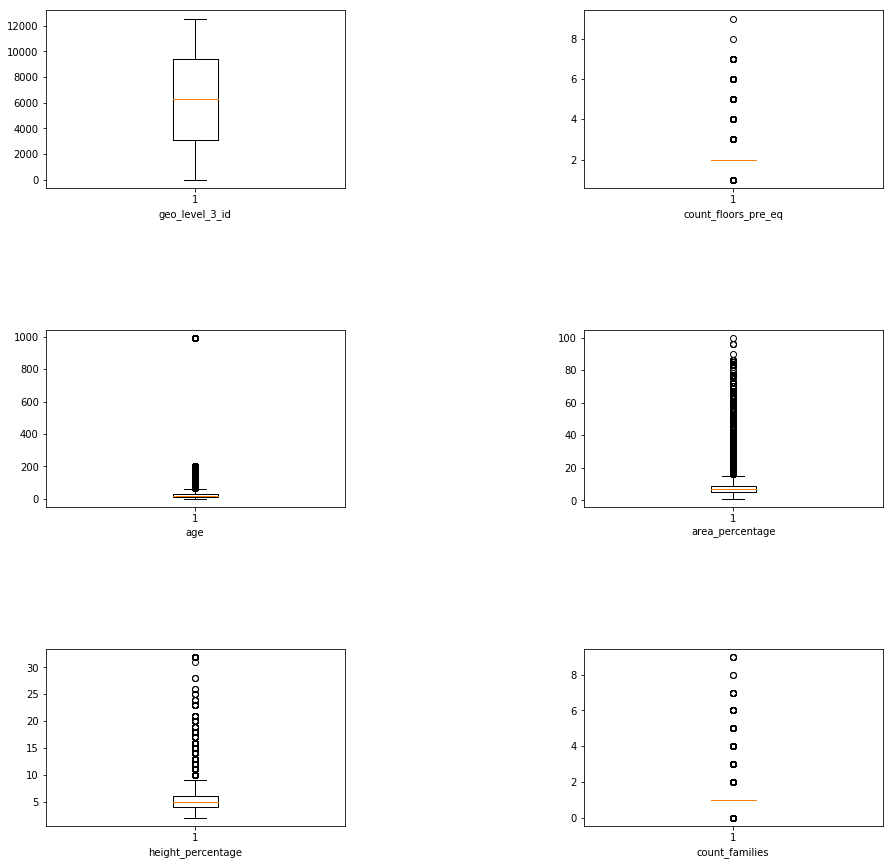

In [32]:
print(labels['damage_grade'].value_counts())
numerical_features = np.array(['geo_level_3_id',
'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families'
])
categorical_features = [i for i in df.columns.values if i not in numerical_features]
drawBoxPlot(feature = numerical_features, label = 'damage_grade', df_ = df,  subplots = True, nrows = 3, ncolumns = 2, single = True)

**FROM Above Box plots it is very clear that the dataset suffers from high amount of outliers.** These Can be removed by enforcing a distribution on the data.

In [33]:
df['age'].value_counts()

10     38896
15     36010
5      33697
20     32182
0      26041
25     24366
30     18028
35     10710
40     10559
50      7257
45      4711
60      3612
80      3055
55      2033
70      1975
995     1390
100     1364
65      1123
90      1085
85       847
75       512
95       414
120      180
150      142
200      106
110      100
105       89
125       37
115       21
140        9
130        9
180        7
160        6
170        6
175        5
135        5
145        3
190        3
195        2
165        2
155        1
185        1
Name: age, dtype: int64

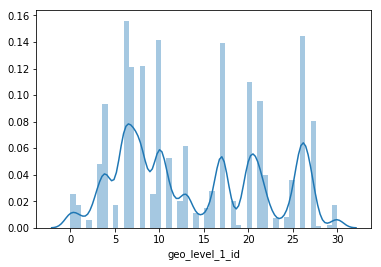

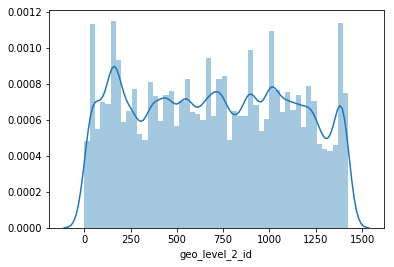

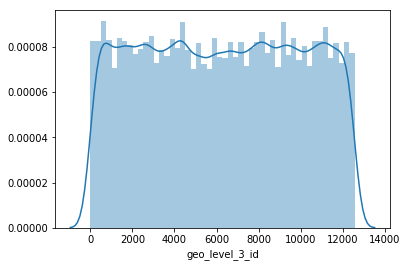

In [34]:
sns.distplot(df['geo_level_1_id'])
plt.figure()
sns.distplot(df['geo_level_2_id'])
plt.figure()
sns.distplot(df['geo_level_3_id'])

In [0]:
df['geo_level_1_id'] = pd.cut(df['geo_level_1_id'], 21)

In [0]:
df['geo_level_2_id'] = pd.cut(df['geo_level_2_id'], 23)

In [37]:
labeled_features = ['geo_level_1_id','geo_level_2_id','land_surface_condition', 'foundation_type',
                    'roof_type', 'ground_floor_type', 'other_floor_type',
                    'position', 'plan_configuration', 'legal_ownership_status',
                    ]
binary_features = np.array([i for i in categorical_features if i not in labeled_features])
print(len(labeled_features))

10


In [38]:
for feature in labeled_features[3:]:
  ct = getCrossTab(feature, 'damage_grade', df)
  print(ct)

damage_grade         1       2      3
foundation_type                      
h                  358     579    511
i                 6004    4354    221
r                10720  125515  82961
u                 3689    8541   2030
w                 4353    9270   1495
damage_grade      1       2      3
roof_type                         
n             13547  106447  62848
q              3926   34009  23641
x              7651    7803    729
damage_grade           1       2      3
ground_floor_type                      
f                  12474  119877  77268
m                     90     343     75
v                  10309   12971   1313
x                   2052   14536   8289
z                    199     532    273
damage_grade         1      2      3
other_floor_type                    
j                 8886  20362  10595
q                 7387  98320  59575
s                 5423   5904    701
x                 3428  23673  16347
damage_grade      1       2      3
position              

In [39]:
## THRESHOLDING BINARY VARIABLES ##
thresholder = VarianceThreshold(0.75*(1 - .75))
threshold = thresholder.fit(df[binary_features[:-1]]).variances_
binary_indices = list(np.argsort(threshold)[::-1])
print(binary_indices[0])
best_binary_features = (binary_features[binary_indices])

6


In [0]:
## Transforming Categorical Features ##
le = {}
labeled_features = np.array(labeled_features)
for feature in labeled_features:
  le[feature] = LabelEncoder()
  df.loc[:, feature] = le[feature].fit_transform(df.loc[:, feature])
## SELECTING BEST CATEGORICAL FEATURES USING CHI SQUARE TEST ##
chi2_selector = SelectKBest(chi2, k = 6)
features_kbest = np.argsort(chi2_selector.fit(df[labeled_features], df['damage_grade']).scores_)[:6]
best_labeled_features = labeled_features[features_kbest]

In [41]:
# REMOVING OUTLIERS ##
selected_features = np.concatenate([best_binary_features, best_labeled_features, numerical_features])
print(selected_features)
for feature in numerical_features:
  df.loc[:, feature]= power_transform(df.loc[:, feature].values.reshape(-1,1), method = 'yeo-johnson')

['has_superstructure_timber' 'has_superstructure_mud_mortar_stone'
 'has_secondary_use' 'has_superstructure_adobe_mud'
 'has_superstructure_bamboo' 'has_superstructure_cement_mortar_brick'
 'has_superstructure_mud_mortar_brick' 'has_secondary_use_agriculture'
 'has_superstructure_rc_non_engineered' 'has_superstructure_stone_flag'
 'has_secondary_use_hotel' 'has_superstructure_cement_mortar_stone'
 'has_superstructure_rc_engineered' 'has_superstructure_other'
 'has_secondary_use_rental' 'has_secondary_use_other'
 'has_secondary_use_industry' 'has_secondary_use_institution'
 'has_secondary_use_school' 'has_secondary_use_health_post'
 'has_secondary_use_gov_office' 'has_secondary_use_use_police'
 'land_surface_condition' 'legal_ownership_status' 'position'
 'other_floor_type' 'plan_configuration' 'foundation_type'
 'geo_level_2_id' 'roof_type' 'geo_level_1_id' 'ground_floor_type'
 'geo_level_3_id' 'count_floors_pre_eq' 'age' 'area_percentage'
 'height_percentage' 'count_families']


In [69]:
sc = StandardScaler()
for feature in numerical_features:
  df[feature] = sc.fit_transform(df[feature].values.reshape(-1,1))
df['age'] = pd.cut(df['age'],10)
le['age'] = LabelEncoder()
df['age'] = le['age'].fit_transform(df['age'])
print("Passed out scaling")
X = df[selected_features]
X = pd.get_dummies(X, columns = best_labeled_features)
y = df['damage_grade']
numerical_features = np.array(numerical_features)
X_std = sc.fit_transform(X)
lr = LogisticRegressionCV(penalty='l2', Cs=10, solver='lbfgs', multi_class= 'multinomial')
model = RandomForestClassifier(random_state = 0, n_estimators = 200)
adaboost = AdaBoostClassifier(base_estimator = model, random_state = 0, n_estimators = 3)
xgboost = XGBClassifier(n_estimators = 500, objective = 'multi:softmax', subsample=0.8, colsample_bytree=0.8, max_depth = 6, scale_pos_weight = 1)
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.2, stratify = y, random_state = 42)

Passed out scaling


In [70]:
xgboost.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [71]:

preds = xgboost.predict(X_test)
preds
f1_ = f1_score(y_test, preds, average = 'micro')
print(f1_)

0.7251587651810212


In [0]:
xgboost.save_model('0001.model')

In [73]:
xgboost.dump_model('dump.raw.txt')

AttributeError: ignored